In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [2]:
# Uncomment and run if you haven't previously installed these packages
# !pip install pillow tifffile natsort imagecodecs microfilm

In [3]:
from PIL import Image
import tifffile
from natsort import natsorted, ns
import imagecodecs
import skimage.io
from microfilm.microanim import Microanim
from microfilm import microplot

# Set experiment-specific file locations

In [4]:
# Identify name and virtual machine location of meta data file
# Plate map should list the row and column in number format
# as well as any additional information - strain, media, treatment, etc - in columns
meta_data_name = '/home/stoops/Working_Scripts/phenix-data-manipulation/20210806_metadata.csv'

# Identify directory containing images
directory_name = '/data/Phenix-archive/Maga/210810-OrganoidTimelapse/organoids_calvin25_2021-08-06/Images/'

In [5]:
# Create directories for data storage if they do not already exist
!mkdir -p Data/timeseries
!mkdir -p Data/zstacks
!mkdir -p Data/animations

# Import Plate Map

In [6]:
# Import plate map from location on virtual machine
meta_data = pd.read_csv(meta_data_name)

# Create list of parameters
parameters = list(meta_data.columns)
if 'row' in parameters: parameters.remove('row')
if 'col' in parameters: parameters.remove('col')

# Create list of unique conditions
condition_lists = []
for cnd_type in parameters:
    uniques = np.sort(meta_data[cnd_type].unique())
    condition_lists.append(uniques)

# Match parameters to conditions in dictionary
parameter_set = dict(zip(parameters, condition_lists))
print(parameter_set)

# Check that metadata was imported and looks accurate
meta_data

{'compound': array(['tunicamycin', 'untreated'], dtype=object), 'concentration': array(['0.2x', '1x'], dtype=object), 'replicate': array([1, 2, 3])}


,row,col,compound,concentration,replicate
0,4,4,untreated,1x,1
1,4,5,untreated,1x,2
2,4,6,untreated,1x,3
3,4,7,untreated,0.2x,1
4,4,8,untreated,0.2x,2
5,4,9,untreated,0.2x,3
6,5,4,tunicamycin,1x,1
7,5,5,tunicamycin,1x,2
8,5,6,tunicamycin,1x,3
9,5,7,tunicamycin,0.2x,1


# Generate list of filenames matched with plate map

In [7]:
# Search experiment directory for tiff files and add to dataframe
all_paths_list = glob.glob(directory_name + '*.tiff')  
all_paths = pd.DataFrame(all_paths_list, columns = ['path'])

# Regular expression to extract image information from filename
match_str = r'r(?P<row>\d{2})c(?P<column>\d{2})f(?P<fov>\d{2})p(?P<z_position>\d{2})-ch(?P<channel>1|2)sk(?P<timepoint>\d{1,3})fk1fl1'
extracted = all_paths['path'].str.extract(match_str, expand=True)

# Concatenate extracted information to list of filenames
all_paths_ext = pd.concat([all_paths, extracted], axis=1)

# Convert data extracted from filename from string into integers
all_paths_ext['row'] = all_paths_ext['row'].astype(int)
all_paths_ext['column'] = all_paths_ext['column'].astype(int)
all_paths_ext['fov'] = all_paths_ext['fov'].astype(int)
all_paths_ext['z_position'] = all_paths_ext['z_position'].astype(int)
all_paths_ext['channel'] = all_paths_ext['channel'].astype(int)
all_paths_ext['timepoint'] = all_paths_ext['timepoint'].astype(int)

# Check that information was added to the dataframe
all_paths_ext.head()

,path,row,column,fov,z_position,channel,timepoint
0,/data/Phenix-archive/Maga/210810-OrganoidTimel...,4,4,7,3,1,98
1,/data/Phenix-archive/Maga/210810-OrganoidTimel...,5,7,9,3,1,46
2,/data/Phenix-archive/Maga/210810-OrganoidTimel...,4,9,8,3,1,71
3,/data/Phenix-archive/Maga/210810-OrganoidTimel...,4,6,9,3,1,71
4,/data/Phenix-archive/Maga/210810-OrganoidTimel...,5,8,8,3,1,46


In [8]:
# Extract and store details about the experimental setup
nslices = all_paths_ext['z_position'].max()
print(f'Number of slices: {nslices}')
# Choose a default slice number halfway through the stack
default_z = int(nslices/2)

nchannels = all_paths_ext['channel'].max()
print(f'Number of channels: {nchannels}')

ntimepoints = all_paths_ext['timepoint'].max()
print(f'Number of timepoints: {ntimepoints}')

nfov = all_paths_ext['fov'].max()
print(f'Fields imaged per well: {nfov}')

Number of slices: 4
Number of channels: 2
Number of timepoints: 100
Fields imaged per well: 9


In [9]:
# Matches information from the metadata to the information in the dataframe
all_files = pd.merge(all_paths_ext, meta_data, how='left', left_on=['row','column'], right_on=['row','col'])

# Drops duplicate column info from the metadata
all_files = all_files.drop(['col'], axis=1)

# Create header rows to be able to use these for functions below
all_files.set_index(['compound','concentration','fov','channel','timepoint','z_position','replicate'], inplace=True, drop=True)

all_files.head()

path  \
compound    concentration fov channel timepoint z_position replicate                                                      
untreated   1x            7   1       98        3          1          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
tunicamycin 0.2x          9   1       46        3          1          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
untreated   0.2x          8   1       71        3          3          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
            1x            9   1       71        3          3          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
tunicamycin 0.2x          8   1       46        3          2          /data/Phenix-archive/Maga/210810-OrganoidTimel...   

                                                                      row  \
compound    concentration fov channel timepoint z_position replicate        
untreated   1x            7   1       98        3          1            4   
tunicamycin 0.2x          9   1       46        3          1            5   
untreated   0.2x          8   1       71        3          3            4   
            1x            9   1       71        3          3            4   
tunicamycin 0.2x          8   1       46        3          2            5   

                                                                      column  
compound    concentration fov channel timepoint z_position replicate          
untreated   1x            7   1       98        3          1               4  
tunicamycin 0.2x          9   1       46        3          1               7  
untreated   0.2x          8   1       71        3          3               9  
            1x            9   1       71        3          3               6  
tunicamycin 0.2x          8   1       46        3          2               8

# Plot images

In [53]:
# Define functions
def plot_specific_image(compound,concentration,replicate,fov,channel,timepoint,z_pos, **kwargs):
    '''
    Plots image specified by arguments passed to the function
    
    Parameters:
    compound (str): drug condition
    concentration (str): concentration condition
    replicate (int): biological replicate to plot
    fov (int): field of view within the well to plot
    channel (int): channel number to plot
    timepoint (int): timepoint to plot
    z_pos (int): position within the z-stack to plot
    
    '''
    
    # Generate the set of filenames where the conditions are equal to those set when calling the function
    image_path = all_files.xs((compound,concentration,replicate,fov,channel,timepoint,z_pos), 
                              level=['compound','concentration','replicate','fov','channel','timepoint','z_position'])['path'].values[0]
    # print(image_path)

    # Load the images associated with the above filenames into numpy arrays
    img = plt.imread(image_path)
    img_min = np.percentile(img, 2)
    img_max = np.percentile(img, 99.8)
    
    # Display image with title and no axes
    plt.imshow(img, cmap='gray', vmin=img_min, vmax=img_max)
    plt.suptitle(compound + ' (' + concentration + ')')
    plt.xticks([])
    plt.yticks([])
    plt.show()


def plot_2channel_image(compound,concentration,replicate=1,fov=5,timepoint=1,z_pos=default_z, **kwargs):
    '''
    Plots 2-color image specified by arguments passed to the function
    
    Parameters:
    compound (str): drug condition
    concentration (str): concentration condition
    replicate (int): biological replicate to plot
    fov (int): field of view within the well to plot
    timepoint (int): timepoint to plot
    z_pos (int): position within the z-stack to plot
    
    '''
    
    # Generate the set of filenames where the conditions are equal to those set when calling the function
    image_path = all_files.xs((compound,concentration,replicate,fov,timepoint,z_pos), 
                              level=['compound','concentration','replicate','fov','timepoint','z_position'])['path'].values[:]
    paths_sorted = np.sort(image_path)
    
    # Create figure object
    fig, (ax1, ax2) = plt.subplots(1,2)
    
    # Read and plot the DIC image
    dic = plt.imread(paths_sorted[0])
    ax1.imshow(dic, cmap='gray')
    ax1.set_title('DIC')
    ax1.axis('off')
    
    # Read and plot the RFP image
    rfp = plt.imread(paths_sorted[1])
    rfp_min = np.percentile(rfp, 2)
    rfp_max = np.percentile(rfp, 99.8)
    ax2.imshow(rfp, cmap='gray', vmin=rfp_min, vmax=rfp_max)
    ax2.set_title('concentration')
    ax2.axis('off')
    
    plt.suptitle(compound + ' (' + concentration + ' concentration)', fontsize=20)
    plt.show()
    
    
def plot_timecourse_hrz(compound,concentration,replicate=1,fov=5,channel=1,z_pos=default_z, interval=10):    
    '''
    Plots every nth image of a timeseries and saves figure to timeseries directory
    
    Parameters:
    compound (str): drug condition
    concentration (str): concentration condition
    replicate (int): biological replicate to plot
    fov (int): field of view within the well to plot
    channel (int): channel number to plot
    z_pos (int): position within the z-stack to plot, set to nslices/2 by default
    interval (int): plot every nth image
    
    '''
    
    # Generate the set of filenames where the conditions are equal to those set when calling the function
    image_path = all_files.xs((compound,concentration,replicate,fov,channel,z_pos), 
                              level=['compound','concentration','replicate','fov','channel','z_position'])['path'].values[:]
    # Sort filenames so 10 is after 9 not after 1 (natural sort, not text sort)
    paths_sorted = natsorted(image_path, key=lambda y: y.lower())
    
    # Define the step size for plotting the time series, i.e. every nth image
    ntimepoints = len(paths_sorted)
    npanels = int(ntimepoints/interval)
    
    # Create the figure object
    fig, ax = plt.subplots(1, npanels+1, figsize=(30,4))
    
    # Loop through the list of filenames and plot every nth one based on the interval set above
    def plot_interval(plot_num, col_num, paths_sorted):
        a = ax[plot_num]
        img = plt.imread(paths_sorted[col_num])
        a.imshow(img, cmap='gray')
        a.plot()
        a.title.set_text(f'{col_num}h')
        a.axis('off')
        
    for i in range(npanels):
        # Constrain column number to the length of the list
        col_num = min(max(i*interval,0),len(paths_sorted)-1) 
        plot_interval(i, col_num, paths_sorted)
    
    # Always include the last timeframe
    plot_interval(npanels, len(paths_sorted)-1, paths_sorted)

    plt.suptitle(f'{compound} replicate {replicate}', fontsize=20)
    plt.show()
    
    # Save timecourse file as an .svg file
    fig.savefig('Data/timeseries/' + compound + '_' + concentration + '_r' + str(replicate) + '_f' + str(fov) + '_z' + str(z_pos) + '.svg', dpi=300)
    

def create_z_stack(compound,concentration,replicate=1,fov=5,channel=1,z_pos=default_z, **kwargs):
    '''
    Creates z-stack compiling all of the timepoints for the parameters specified and saves to zstack directory
    
    Parameters:
    compound (str): drug condition
    concentration (str): concentration condition
    replicate (int): biological replicate
    fov (int): field of view within the well
    channel (int): channel number
    z_pos (int): position within the z-stack
    
    '''    
    
    # Generate the set of filenames where the conditions are equal to those set when calling the function
    image_path = all_files.xs((compound,concentration,replicate,fov,channel,z_pos), 
                              level=['compound','concentration', 'replicate','fov','channel','z_position'])['path'].values[:]
    # Sort the pathnames using a package that puts in natural order despite absence of leading zeroes
    paths_sorted = natsorted(image_path, key=lambda y: y.lower())
    
    # Create a stack and save as tiff to directory
    file_name = 'Data/zstacks/' + compound + '_' + concentration + '_r' + str(replicate) + '_f' + str(fov) + '_c' + str(channel) + '_z' + str(z_pos) + '.tif'
    with tifffile.TiffWriter(file_name) as stack:
        for col_num in range(ntimepoints):
            stack.save(
                tifffile.imread(paths_sorted[col_num]),
                photometric='minisblack',
                contiguous=True
            )
            
    return file_name

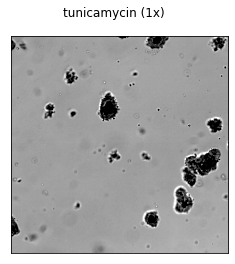

In [11]:
# Returns image for parameters specified
plot_specific_image(compound='tunicamycin',concentration='1x',replicate=1,fov=2,channel=1,timepoint=1,z_pos=4)

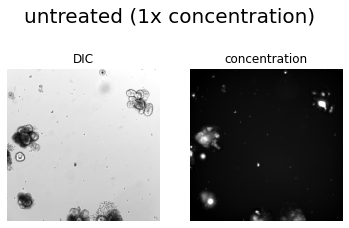

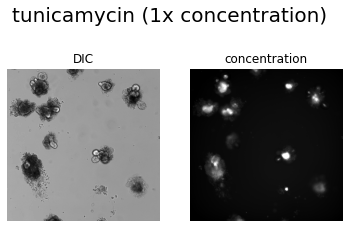

In [12]:
# Plot DIC and fluorescent image side by side for given condition
plot_2channel_image('untreated','1x',timepoint=100)
plot_2channel_image('tunicamycin','1x',timepoint=100)

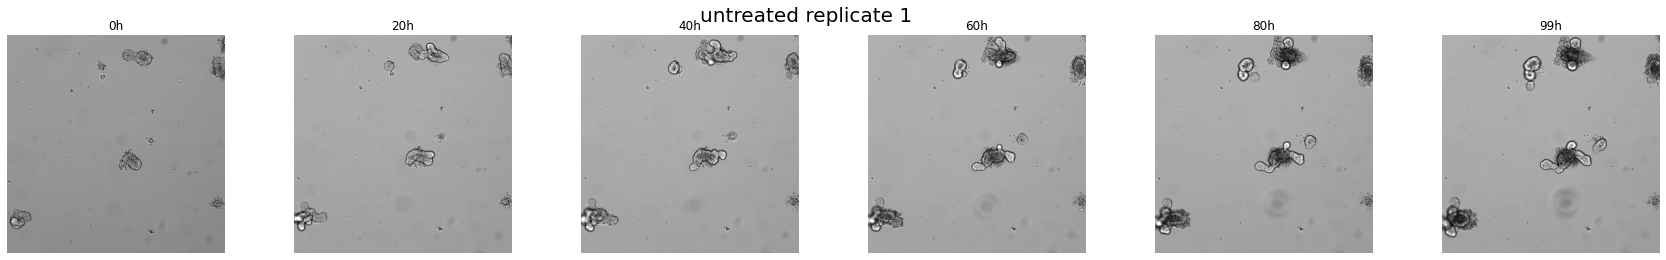

In [15]:
# Create plot of every nth image in a z-stack, where n=interval
plot_timecourse_hrz('untreated','0.2x',replicate=1, fov=8, interval=20)

In [54]:
# Create 2D time series z-stacks at the focal plane of choice for both channels
create_z_stack('untreated','1x',replicate=3,fov=1, channel=2)
create_z_stack('untreated','1x',replicate=3,fov=4)

'Data/zstacks/untreated_1x_r3_f4_c1_z2.tif'

In [83]:
def create_animation(compound,concentration,replicate=1,fov=5,channel=1,z_pos=default_z, **kwargs):
    '''
    Creates z-stack for channel and then makes a gif
    
    Parameters:
    compound (str): drug condition
    concentration (str): concentration condition
    replicate (int): biological replicate
    fov (int): field of view within the well
    channel (int): channel of interest
    z_pos (int): position within the z-stack
    
    '''    
    # Create the z_stack tiff and read it into a numpy array
    dic_path = create_z_stack(compound,concentration,replicate,fov,channel,z_pos=default_z)
    dic_image = skimage.io.imread(dic_path)

    # Convert to a format that microanim plugin will recognize (channel, timepoint, x, y)
    merge = np.empty((1, 100, 1080, 1080), dtype=np.uint16)
    merge[0,:,:,:] = dic_image

    # Create animation object
    # TOFIX need to determine unit per pixel for scalebar
    microanim = Microanim(data=merge, cmaps=['Greys_r'], fig_scaling=5,
                          unit='FIX', scalebar_size_in_units=10, scalebar_unit_per_pix=0.065,
                          scalebar_font_size=0.04)

    # Add timestamp to the animation
    # TOFIX time stamp doesn't reflect days
    microanim.add_time_stamp('T', 60, location='lower left', timestamp_size=20,timestamp_color='black')

    # Save animation
    # TOFIX generalize filename
    microanim.save_movie('Data/animations/temp_name.gif',fps=10)

    
def create_2color_animation(compound,concentration,replicate=1,fov=5,z_pos=default_z, **kwargs):
    '''
    Creates z-stacks for both channels and then makes a gif
    
    Parameters:
    compound (str): drug condition
    concentration (str): concentration condition
    replicate (int): biological replicate
    fov (int): field of view within the well
    z_pos (int): position within the z-stack
    
    '''    
    
    # Create the z_stack tiffs and read them into numpy arrays
    dic_path = create_z_stack(compound,concentration,replicate,fov,channel=1,z_pos=default_z)
    rfp_path = create_z_stack(compound,concentration,replicate,fov,channel=2,z_pos=default_z)
    dic_image = skimage.io.imread(dic_path)
    rfp_image = skimage.io.imread(rfp_path)

    # Combine single channels to merged array in a format that microanim plugin will recognize
    # (channel, timepoint, x, y)
    merge = np.empty((2, 100, 1080, 1080), dtype=np.uint16)
    merge[0,:,:,:] = dic_image
    merge[1,:,:,:] = rfp_image

    # Create animation object
    # TOFIX need to determine unit per pixel for scalebar
    microanim = Microanim(data=merge, cmaps=['Greys_r','pure_red'], fig_scaling=5,
                          unit='FIX', scalebar_size_in_units=10, scalebar_unit_per_pix=0.065,
                          scalebar_font_size=0.04)

    # Add timestamp to the animation
    # TOFIX time stamp color and increment
    microanim.add_time_stamp('T', 60, location='lower left', timestamp_size=20,timestamp_color='black')

    # Save animation
    # TOFIX generalize filename
    microanim.save_movie('Data/animations/temp_name_2color.gif', fps=15)

Data/zstacks/untreated_1x_r1_f2_c1_z2.tif


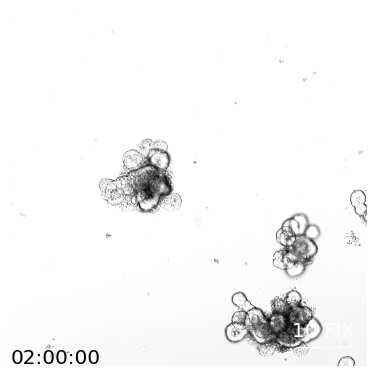

In [84]:
create_animation('untreated','1x',replicate=1,fov=2,channel=1,z_pos=default_z)

uint16


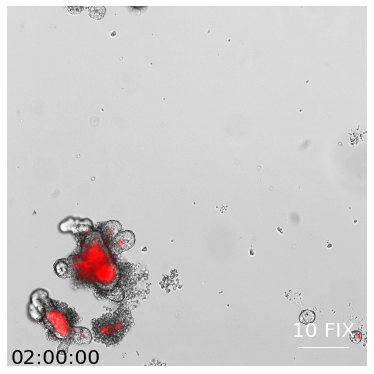

In [86]:
create_2color_animation('untreated','1x',replicate=1,fov=7,z_pos=default_z)